# 🛍️ Project: Personalized E-commerce Recommendations

Goal: 

Predict whether a customer would recommend a product, based on:
- Customer profile (age, gender, location, browsing/purchase behavior)
- Product attributes (price, rating, category, sentiment, etc.)

In [18]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score,
    learning_curve, permutation_test_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import (
    mean_squared_error, r2_score, classification_report, roc_auc_score,
    precision_recall_curve, label_ranking_average_precision_score, ndcg_score
)

## 1. Load and clean data 

In [19]:
import kagglehub

path = kagglehub.dataset_download("suvroo/personalized-recommendations-for-e-commerce")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/anitahuang/.cache/kagglehub/datasets/suvroo/personalized-recommendations-for-e-commerce/versions/1


In [20]:
customer_df = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/personalized-recommendations-for-e-commerce/data/customer_data_collection.csv')
product_df = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/personalized-recommendations-for-e-commerce/data/product_recommendation_data.csv')

In [21]:
# Drop unnecessary columns
def drop_unnamed(df):
    return df.drop(columns=[col for col in df.columns if "Unnamed" in col])

customer_df = drop_unnamed(customer_df)
product_df = drop_unnamed(product_df)

# 2. Preprocessing

**🎯 Objective:**
To prepare the customer and product data for modeling by:
- Parsing list strings into actual Python lists,
- Label encoding categorical variables,
- One-hot encoding multi-label fields (like browsing and purchase histories).


In [22]:
# Parse list strings
for col in ['Browsing_History', 'Purchase_History']:
    customer_df[col] = customer_df[col].apply(ast.literal_eval)
product_df['Similar_Product_List'] = product_df['Similar_Product_List'].apply(ast.literal_eval)

In [23]:
# Label Encoding Categorical Columns

label_cols = ['Gender', 'Location', 'Customer_Segment', 'Holiday', 'Season']
for col in label_cols:
    customer_df[col] = LabelEncoder().fit_transform(customer_df[col])

In [24]:
# Label Encoding Product Features

product_df[['Category', 'Subcategory', 'Brand', 'Holiday', 'Season', 'Geographical_Location']] = \
    product_df[['Category', 'Subcategory', 'Brand', 'Holiday', 'Season', 'Geographical_Location']].apply(LabelEncoder().fit_transform)

In [25]:
# One-Hot Encoding Multi-Label Fields
mlb = MultiLabelBinarizer()
browsing_encoded = pd.DataFrame(mlb.fit_transform(customer_df['Browsing_History']),
                                columns=[f'Browse_{c}' for c in mlb.classes_])
purchase_encoded = pd.DataFrame(mlb.fit_transform(customer_df['Purchase_History']),
                                columns=[f'Purchase_{c}' for c in mlb.classes_])
customer_df = pd.concat([customer_df.drop(['Browsing_History', 'Purchase_History'], axis=1),
                         browsing_encoded, purchase_encoded], axis=1)

# 3. Merge customer and product samples

**🎯 Objective:**

This simulates 20,000 customer-product pairings for recommendation modeling.
Each row now represents a recommendation scenario.


In [44]:
import itertools
import random
import pandas as pd

# Step 1: Sample customers and products
customer_sample = customer_df.sample(n=200, random_state=42).reset_index(drop=True)
product_sample = product_df.sample(n=100, random_state=42).reset_index(drop=True)

# Step 2: Create all possible pairs
pairs = list(itertools.product(customer_sample.index, product_sample.index))

# Step 3: Random sample from all combinations
random.seed(42)
sampled_pairs = random.sample(pairs, k=20000)

# Step 4: Combine into rows
rows = []
for cust_idx, prod_idx in sampled_pairs:
    customer_row = customer_sample.loc[cust_idx].to_dict()
    product_row = product_sample.loc[prod_idx].to_dict()

    # Merge both dicts into one
    combined = {**customer_row, **product_row}
    rows.append(combined)

# Step 5: Final merged DataFrame
merged_df = pd.DataFrame.from_records(rows)

# Section 4: Classification Setup – Binary Prediction

**🎯 Objective:**
We convert the continuous recommendation probability (Probability_of_Recommendation) into a binary classification target called Recommend_Class.

This allows us to frame the problem as:
- Would this customer likely recommend this product?

We will build a classifier using customer attributes, browsing/purchase history, and product features.



In [45]:
# Step 1: Create Binary Target Variable
merged_df['Recommend_Class'] = (merged_df['Probability_of_Recommendation'] >= 0.5).astype(int)

In [46]:
# Step 2: Prepare Features and Target
X_class = merged_df.drop([
    'Customer_ID', 'Product_ID', 'Probability_of_Recommendation', 'Recommend_Class', 'Similar_Product_List'
], axis=1)
y_class = merged_df['Recommend_Class']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
scaler_c = StandardScaler()
X_train_c = scaler_c.fit_transform(X_train_c)
X_test_c = scaler_c.transform(X_test_c)

In [ ]:
# Step 3: Feature Correlation Analysis
correlations = merged_df.drop(['Customer_ID', 'Product_ID', 'Similar_Product_List'], axis=1).corr()
correlations['Probability_of_Recommendation'].sort_values(ascending=False)

In [ ]:
# Step 4: Unique Probability Distribution
print("Unique probabilities:")
print(merged_df['Probability_of_Recommendation'].unique())

In [49]:
# Step 5: Train Classifier with Cross-Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf_cv_scores = cross_val_score(RandomForestClassifier(), X_train_c, y_train_c, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC scores (Classifier):", clf_cv_scores)
print("Mean CV ROC AUC:", np.mean(clf_cv_scores))

Cross-validated ROC AUC scores (Classifier): [1. 1. 1. 1. 1.]
Mean CV ROC AUC: 1.0


# Section 4.1: Threshold Analysis

This section visualizes how model performance changes when you shift the classification threshold (e.g., from 0.5 to 0.7). It helps with:

Making decisions based on confidence: 
- You might only recommend a product if you're 80%+ sure a user will like it.

Balancing between precision & recall depending on business goals:
- More precision → recommend only highly likely matches
- More recall → show more products, even if less certain

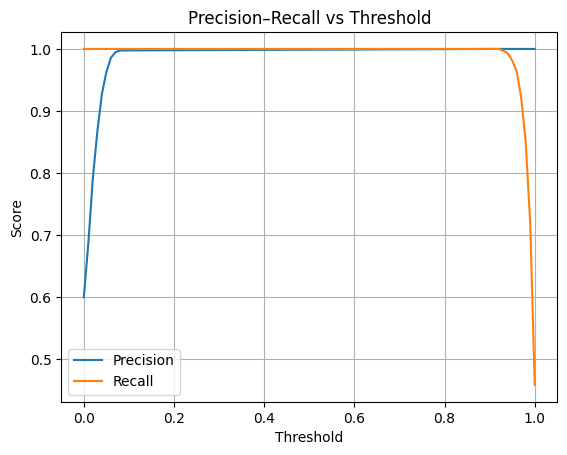

In [50]:
# Step 6: Tuning the Classification Threshold
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
import matplotlib.pyplot as plt

clf = RandomForestClassifier()
clf.fit(X_train_c, y_train_c)
y_probs = clf.predict_proba(X_test_c)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_c, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

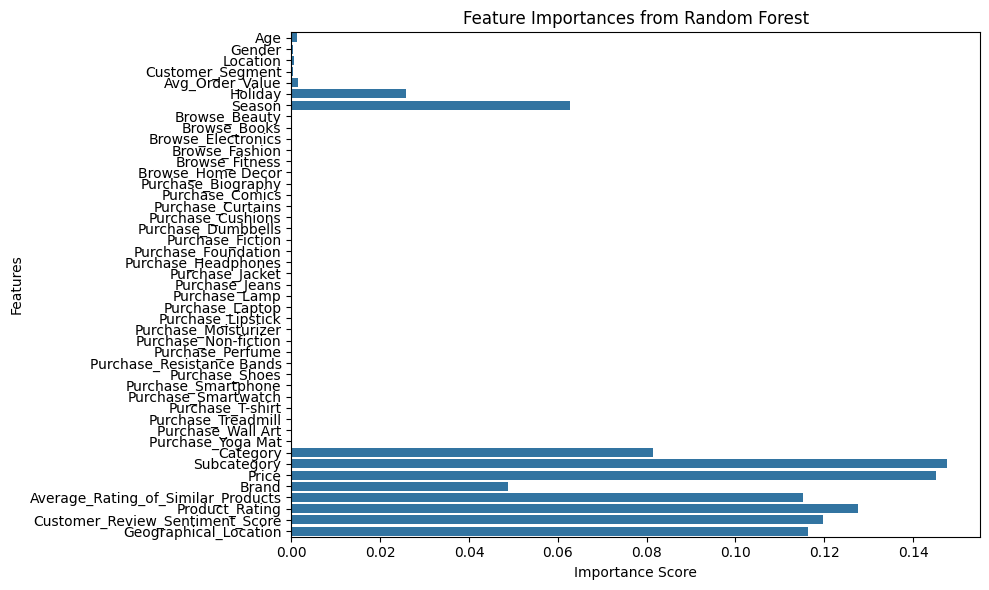

In [61]:
# Step 6.1: Feature Importance Chart
import pandas as pd
import seaborn as sns

feature_importances = pd.Series(clf.feature_importances_, index=X_class.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [51]:
# Step 7: Classification Report
y_pred_c = clf.predict(X_test_c)
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_c))
print("ROC AUC Score:", roc_auc_score(y_test_c, y_probs))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1601
           1       1.00      1.00      1.00      2399

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

ROC AUC Score: 1.0


In [52]:
# Step 8: Prediction Result Inspection
results_df = pd.DataFrame({
    'Predicted_Label': y_pred_c,
    'True_Label': y_test_c.values,
    'Prediction_Probability': y_probs
})

results_df = results_df.sort_values(by='Prediction_Probability', ascending=False)
# print(results_df)

In [53]:
# Step 9: Group Predictions by Probability
grouped = results_df.groupby(['Prediction_Probability', 'Predicted_Label']).size().reset_index(name='Count')
grouped = grouped.sort_values(by='Prediction_Probability', ascending=False)
print(grouped.head(10))

    Prediction_Probability  Predicted_Label  Count
17                    1.00                1   1100
16                    0.99                1    624
15                    0.98                1    315
14                    0.97                1    171
13                    0.96                1    102
12                    0.95                1     42
11                    0.94                1     29
10                    0.93                1      9
9                     0.92                1      7
8                     0.08                0      6


# 4.2 Multilabel Ranking Metrics

**🎯 Goal:**

Instead of just classifying recommendations as “yes” or “no,” we now evaluate how well the model ranks products based on the predicted recommendation likelihood.

**🛠️ What the Code Does:**
- Selects the first 10 customer-product pairs
- Simulates actual relevance using Recommend_Class
- Compares the predicted recommendation scores

**🧪 Metrics Used:**
- label_ranking_average_precision_score: How well relevant items are ranked above non-relevant ones
- ndcg_score: A normalized ranking quality score (higher is better)

In [54]:
from sklearn.metrics import label_ranking_average_precision_score, ndcg_score

y_true_rank = np.tile((merged_df['Recommend_Class'].values[:10] == 1).astype(int), (1, 1))
y_score_rank = np.tile(merged_df['Probability_of_Recommendation'].values[:10], (1, 1))

print("Label Ranking Average Precision Score:", label_ranking_average_precision_score(y_true_rank, y_score_rank))
print("NDCG Score:", ndcg_score(y_true_rank, y_score_rank))

Label Ranking Average Precision Score: 1.0
NDCG Score: 1.0


In [55]:
# Step 10: Visualize Top Products for a Customer
customer_id = merged_df.iloc[0]['Customer_ID']
customer_products = merged_df[merged_df['Customer_ID'] == customer_id]
ranked_products = customer_products.sort_values(by='Probability_of_Recommendation', ascending=False)
print(ranked_products[['Product_ID', 'Probability_of_Recommendation', 'Recommend_Class']].head(5))

      Product_ID  Probability_of_Recommendation  Recommend_Class
8956       P8687                           1.00                1
14413     P11753                           0.99                1
18843      P8252                           0.98                1
2943       P5154                           0.98                1
1631       P6625                           0.97                1


In [60]:
# Step 11: Top-3 Recommendations per Customer
ranked_all = merged_df.sort_values(by=['Customer_ID', 'Probability_of_Recommendation'], ascending=[True, False])
top3_per_customer = ranked_all.groupby('Customer_ID').head(3)
# top3_per_customer = top3_per_customer[top3_per_customer['Probability_of_Recommendation'] >= 0.5]
print(top3_per_customer[['Customer_ID', 'Product_ID', 'Probability_of_Recommendation']])

      Customer_ID Product_ID  Probability_of_Recommendation
736        C10001      P8687                           1.00
14547      C10001     P11753                           0.99
3410       C10001      P8252                           0.98
2037       C10054      P8687                           1.00
294        C10054     P11753                           0.99
...           ...        ...                            ...
13283       C9894     P11753                           0.99
11929       C9894      P8252                           0.98
14286       C9965      P8687                           1.00
11285       C9965     P11753                           0.99
1690        C9965      P5154                           0.98

[600 rows x 3 columns]


In [57]:
print(merged_df[merged_df['Customer_ID'] == customer_id].shape)


(100, 50)
